<a href="https://colab.research.google.com/github/rubygitflow/Glossary-extraction/blob/main/%D0%A4%D0%B5%D0%B2%D1%80%D0%B0%D0%BB%D1%8C%D1%81%D0%BA%D0%B8%D0%B9_%D0%BA%D1%83%D1%80%D1%81_Bocharov_%D0%94%D0%B8%D0%BF%D0%BB%D0%BE%D0%BC%D0%BD%D0%B0%D1%8F_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The research project — Glossary extraction

In [1]:
!nvidia-smi

Sat Oct  3 22:17:33 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Подключение библиотек

In [2]:
!pip install tf2crf

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model # Импортируем модели keras: Model
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, concatenate, Activation, MaxPooling1D, Conv1D, BatchNormalization, Conv2DTranspose, Lambda, LSTM, GRU, Bidirectional # Импортируем стандартные слои keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras import backend as K # Импортируем модуль backend keras'а
from tensorflow.keras.optimizers import Adam # Импортируем оптимизатор Adam
from tensorflow.keras import utils # Импортируем модуль utils библиотеки tensorflow.keras для получения OHE-представления
from tensorflow.keras.preprocessing import image # Импортируем модуль image для работы с изображениями
import matplotlib.pyplot as plt # Импортируем модуль pyplot библиотеки matplotlib для построения графиков
import collections
%matplotlib inline
import numpy as np # Импортируем библиотеку numpy
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report # статистика точности предсказания по классам
import random
import datetime
import time

import xml.etree.ElementTree as ET
import re

import os # Импортируем библиотеку os для работы с фаловой системой
from google.colab import files # Импортируем Модуль files для работы с файлами
from google.colab import drive # Подключаем гугл-диск

from tf2crf import CRF

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


# Сегментация текста

## Чтение и верификация данных (парсим XML). 

Ссылки на файлы данных:

База_словарей_test_2.docx : https://drive.google.com/file/d/1ASKpcdCdseRT5vN9TUnoX8cntU0XwWij/view?usp=sharing

База_словарей_train_2.docx : https://drive.google.com/file/d/1SBH2q6desTLitDiEJxPV0w2gSQVm10sI/view?usp=sharing

База_словарей_test_2.xml : https://drive.google.com/file/d/1J6eg_I4u60xV-Yl1hAKkf0c3jaewp5dZ/view?usp=sharing

База_словарей_train_2.xml : https://drive.google.com/file/d/1irLUUyMHV2URDi6fSSl8b6_bxkpCyAlJ/view?usp=sharing


In [5]:
color_meaning = {'00ffff':'термин', 'ffff00':'связка', '00ff00':'определение', 'd3d3d3':'расшифровка', 
                 'ff00ff':'дубль-термин', 'ff0000':'дубль-связка', '808000':'дубль-определение', '0000ff':'дубль-расшифровка',
                 'cyan':'термин','yellow':'связка','green':'определение', 'lightgray':'расшифровка',	                 
                 'magenta':'дубль-термин', 'red':'дубль-связка','darkyellow':'дубль-определение', 'blue':'дубль-расшифровка'}

                 #создаем словарь соответствий цвет-значение   

In [6]:
color_dic = {'термин':0,'связка':1,'определение':2,'расшифровка':3,
			       'дубль-термин':4,'дубль-связка':5,'дубль-определение':6,'дубль-расшифровка':7}

zero_symbol = 'o'

colors_count = len(color_dic) + 1 # количество уникальных тегов (не забываем про тег отсутствия класса для разметки)

skip_amount = colors_count  # кол-во пропускаемых строк под легенду при считывании данных (здесь учитывается, что есть пусая строка, в списке тегов последнее значение используется под отсутствующий класс для разметки)

In [7]:
colors_count

9

In [8]:
#названия необходимых тегов
r = '{http://schemas.openxmlformats.org/wordprocessingml/2006/main}r'
rpr = '{http://schemas.openxmlformats.org/wordprocessingml/2006/main}rPr'
t = '{http://schemas.openxmlformats.org/wordprocessingml/2006/main}t'
shd = '{http://schemas.openxmlformats.org/wordprocessingml/2006/main}shd'
fill = '{http://schemas.openxmlformats.org/wordprocessingml/2006/main}fill'
highlight = '{http://schemas.openxmlformats.org/wordprocessingml/2006/main}highlight'
val = '{http://schemas.openxmlformats.org/wordprocessingml/2006/main}val'

Библиотека функций

In [10]:
def load_xml(filename, paragraphs_amount):
    # загружаем тестовую выборку
    test_tree = ET.parse(filename)

    test_root = test_tree.getroot()
    test_body = test_root[0]
    test_row_count = paragraphs_amount + skip_amount
    return list(iter(test_body))[:test_row_count]

In [11]:
def insert_space(text, index):
  return text[:index] + ' ' + text[index:]

In [21]:
def pars_xml(ps):
    # Массивы данных по параграфам
    paragraphs = []
    tags = []
    # Массив фактических цветов в файле исходных данных
    colors = set() # все цвета в документе
    # длина массива лексем в параграфе
    max_paragraph_len = 0  # Максимальная длина предложения
    max_paragraph_len_ind = -1  # Индекс предложения с максимальной длиной

    for i, paragraph in enumerate(ps): # проходим по всем абзацам
        if i > colors_count - 1:     # пропускаем легенду для цветовой разметки    
            phrases_list = paragraph.findall(r) # находим все фразы (часть новости)
            p_words = [] # список сущностей в абзаце
            tags_w = [] # список семантических цветов для слов в абзаце

            for ind, phrase in enumerate(phrases_list): # проходим по всем фразам в абзаце
                words = [] # список сущностей во фразе
                y_list = [] # категории для сущностей во фразе

                text = phrase.find(t).text # получаем текст, содержащийся во фразе
                text = re.sub(r'(\[\d+\])', '', text) # удаляем из текста числовые сссылки на библиографию 

                # выделение знаков препинания
                text = text.replace('.-', '. -')

                len_text = len(text)
                if text.find('.') > -1:
                  text_dot = text
                  for j in reversed(range(len_text)):
                    if text[j]=='.':
                      # игнорируем инициалы и сокращения
                      if not ( (j > 2 and  text[j-2]=='.') or \
                              (j < (len_text - 2) and text[j+2]=='.') or \
                              (j > 2 and  text[j-2]==' ') or \
                              (j > 2 and  text[j-3]==' ') ):
                        text_dot = insert_space(text_dot, j)
                else:
                  text_dot = text

                len_text = len(text_dot)
                        
                if text_dot.find(',') > -1:
                  text_comma = text_dot
                  for j in reversed(range(len_text)):
                    if text_dot[j]==',':
                      if not (j < (len_text - 1) and text_dot[j+1].isdigit()): # число через запятую
                        if j < (len_text - 1) and not text_dot[j+1] in [" ", "\t"]:
                          text_comma = insert_space(text_comma, j+1)
                        text_comma = insert_space(text_comma, j)
                else:
                  text_comma = text_dot

                text_comma = text_comma.replace('!', ' !')
                text_comma = text_comma.replace('?', ' ?')
                text_comma = text_comma.replace(':', ' :')

                text_comma = text_comma.replace('=', ' = ')
                text_comma = text_comma.replace('/', ' / ')
                text_comma = text_comma.replace('(', ' ( ')
                text_comma = text_comma.replace(')', ' ) ')
                text_comma = text_comma.replace('[', ' [ ')
                text_comma = text_comma.replace(']', ' ] ')
                text_comma = text_comma.replace('{', ' { ')
                text_comma = text_comma.replace('}', ' } ')
                text_comma = text_comma.replace('<', ' < ')
                text_comma = text_comma.replace('>', ' > ')
                text_comma = text_comma.replace('"', ' " ')
                text_comma = text_comma.replace('„', ' „ ')
                text_comma = text_comma.replace('“', ' “ ')
                text_comma = text_comma.replace('«', ' « ')
                text_comma = text_comma.replace('»', ' » ')
                text_comma = text_comma.replace(';', ' ; ')
                text_comma = text_comma.replace('\xa0', '')
                text_comma = text_comma.replace('\x301', '')
                text_comma = text_comma.replace('\u0301', '')
                text_comma = text_comma.replace('\ufeff', '')
                          
                text_comma = text_comma.replace('  ', ' ')
                text_comma = text_comma.replace('  ', ' ')

                text_comma = text_comma.strip()      

                if (len(text_comma)>0):
                  text_comma = text_comma.lower()

                  style = phrase.find(rpr) # получаем стили фразы
                  
                  if style.find(shd) is not None: # если размечали через заливку
                      color = style.find(shd).attrib[fill] # получаем значение цвета заливки
                  elif style.find(highlight) is not None: # если размечали через хайлайт
                      color = style.find(highlight).attrib[val] # получаем значение цвета хайлайта
                  else:
                      color = 'white' # иных вариантов выделения в word нет, значит эта фраза не выделена (белый цвет)
                  color = color.lower() # переводим строковое значение цвета в нижний регистр
                  meaning = color_meaning[color] if color in color_meaning else '' # если есть цвет в словаре цвет-значение, то получаем значение. в противном случае у фразы значение не было выделено
                  
                  colors.add(color) # добавляем цвет в словарь всех встреченных цветов, если нужно проанализировать их
                  
                  words = text_comma.split()
                  k = len(words)
                  if meaning in color_dic: # если во фразе присутствует какая-то выделяемая сущность
                    for j in range(k):
                      y_list.append(meaning) # получаем индекс позиции, соответствующей какой-то семантической(смысловой) окраске и устанавливаем по этому индексу абсолютное значение категории
                  else:
                    for j in range(k):
                      y_list.append(zero_symbol)

                  p_words += words  # список сущностей в параграфе
                  tags_w += y_list # список семантических цветов для слов в параграфе

            paragraphs.append(p_words)
            tags.append(tags_w)
              
            if len(p_words) >= max_paragraph_len: 
              max_paragraph_len = len(p_words)
              max_paragraph_len_ind = i - skip_amount

        if i%100==0:
            print('line',i)

    return     paragraphs, tags, colors, max_paragraph_len, max_paragraph_len_ind

In [13]:
def class_stat(paragraphs, tags):
  classes = np.zeros((colors_count))
  print('Длина массива разметки текста:', len(tags))
  print("\nПеречень фраз без неклассифицированных лексем:")
  for i, elem in enumerate(tags):
    if zero_symbol in elem:
      if len(set(elem))==1:
        classes[0] += 1
    else:
      print("paragraphs[{}]".format(i), '=',paragraphs[i])
      print("tags[{}]".format(i), '=',tags[i])
      print(" ")
    for item in list(color_dic.keys()):
      if item in elem:
        real_index = int(color_dic[item]) + 1
        classes[real_index] += 1
  print("\nСтатистика по классам")
  for i in range(len(classes)):
    if i==0:
      print('Фраз без определительных структур:',classes[0])
    else:
      key=list(color_dic.keys())[list(color_dic.values()).index(i-1)] # ключ по значению
      print('Фраз с категорией {}: {}'.format(key, classes[i]))

In [69]:
def draw_paragraphs_stat(paragraphs):
  counter = []
  for elem in paragraphs:
    counter.append(len(elem))

  plt.figure(figsize=(27, 5))
  plt.grid(True)
  plt.bar(range(len(paragraphs)), counter)
  plt.suptitle('Распределение длин абзацев')
  plt.show()

  dic_counter = collections.Counter(train_counter)
  print('Collections',dic_counter)

  plt.figure(figsize=(15, 5))
  plt.grid(True)
  plt.bar(train_count.keys(), train_count.values())
  plt.suptitle('Статистика по длинам абзацев')
  plt.show()

  return counter, dic_counter

### Обучающая выборка

In [36]:
paragraphs_amount = 640
ps_train = load_xml('/content/drive/My Drive/Базы/NLP/База_словарей_train_2.xml', paragraphs_amount)

In [23]:
print(len(ps_train))

649


In [24]:
paragraphs_train, tags_train, train_colors, max_paragraph_len, max_paragraph_len_ind  = pars_xml(ps_train)

line 0
line 100
line 200
line 300
line 400
line 500
line 600


In [26]:
if len(train_colors) > colors_count:
  print('В документе цветов разметки больше допустимого')
train_colors # выведем все цвета, которые мы встретили

{'blue',
 'cyan',
 'darkyellow',
 'green',
 'lightgray',
 'magenta',
 'red',
 'white',
 'yellow'}

In [27]:
print(len(paragraphs_train))
print(len(tags_train))

print('Максимальная длина предложения — max_paragraph_len =',max_paragraph_len)
print('Индекс предложения с максимальной длиной — max_paragraph_len_ind =',max_paragraph_len_ind)

640
640
Максимальная длина предложения — max_paragraph_len = 120
Индекс предложения с максимальной длиной — max_paragraph_len_ind = 282


In [28]:
paragraphs_train[max_paragraph_len_ind]

['существительное',
 'называет',
 'предметы',
 'в',
 'широком',
 'смысле',
 'слова',
 ';',
 'это',
 '—',
 'названия',
 'вещей',
 '(',
 'стол',
 ',',
 'стена',
 ',',
 'окно',
 ',',
 'ножницы',
 ',',
 'сани',
 ')',
 ',',
 'лиц',
 '(',
 'ребёнок',
 ',',
 'девочка',
 ',',
 'юноша',
 ',',
 'человек',
 ')',
 ',',
 'веществ',
 '(',
 'крупа',
 ',',
 'сахар',
 ',',
 'сливки',
 ',',
 'кислота',
 ')',
 ',',
 'живых',
 'существ',
 'и',
 'организмов',
 '(',
 'кошка',
 ',',
 'собака',
 ',',
 'ворона',
 ',',
 'дятел',
 ',',
 'окунь',
 ',',
 'щука',
 ',',
 'бактерия',
 ',',
 'вирус',
 ',',
 'микроб',
 ')',
 ',',
 'фактов',
 ',',
 'событий',
 ',',
 'явлений',
 '(',
 'пожар',
 ',',
 'спектакль',
 ',',
 'беседа',
 ',',
 'каникулы',
 ',',
 'радость',
 ')',
 ',',
 'географические',
 'положения',
 '(',
 'россия',
 ',',
 'байкал',
 ',',
 'оренбург',
 ',',
 'европа',
 ')',
 ',',
 'а',
 'также',
 'качеств',
 ',',
 'свойств',
 ',',
 'действий',
 ',',
 'состояний',
 '(',
 'доброта',
 ',',
 'синева',
 ',',
 'бег'

In [29]:
tags_train[max_paragraph_len_ind]

['термин',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'связка',
 'связка',
 'определение',
 'определение',
 'o',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'o',
 'o',
 'определение',
 'o',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'o',
 'o',
 'определение',
 'o',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'o',
 'o',
 'определение',
 'определение',
 'определение',
 'определение',
 'o',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'o',
 'o',
 'определение',
 'определение',
 'определение',
 'определение',
 'определение',
 'o',

In [31]:
# Корректируем максимальную длину предложения для использования U-net сеток
max_paragraph_len = 128

In [32]:
train_paragraphs_len = len(paragraphs_train)
print('Длина обучающей выборки:', train_paragraphs_len)

Длина обучающей выборки: 640


**Извлекаем статистику по абзацам**

In [33]:
paragraphs_train[0]

['декларативное',
 'программирование',
 '—',
 'парадигма',
 'программирования',
 ',',
 'в',
 'которой',
 'задаётся',
 'спецификация',
 'решения',
 'задачи',
 ',',
 'то',
 'есть',
 'описывается',
 ',',
 'что',
 'представляет',
 'собой',
 'проблема',
 'и',
 'ожидаемый',
 'результат',
 '.']

In [34]:
tags_train[0]

['термин',
 'термин',
 'связка',
 'определение',
 'определение',
 'o',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'дубль-связка',
 'дубль-связка',
 'дубль-расшифровка',
 'дубль-расшифровка',
 'дубль-расшифровка',
 'дубль-расшифровка',
 'дубль-расшифровка',
 'дубль-расшифровка',
 'дубль-расшифровка',
 'дубль-расшифровка',
 'дубль-расшифровка',
 'o']

In [37]:
paragraphs_train[paragraphs_amount - 1]

['maxpooling2d',
 '—',
 'это',
 'способ',
 'уменьшить',
 'количество',
 'параметров',
 'в',
 'нашей',
 'модели',
 ',',
 'переместив',
 'фильтр',
 'пула',
 '2×2',
 'по',
 'предыдущему',
 'слою',
 'и',
 'взяв',
 'максимум',
 '4',
 'значения',
 'в',
 'фильтре',
 '2×2',
 '.']

In [38]:
tags_train[paragraphs_amount - 1]

['термин',
 'связка',
 'связка',
 'определение',
 'определение',
 'определение',
 'определение',
 'определение',
 'определение',
 'определение',
 'o',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'o']

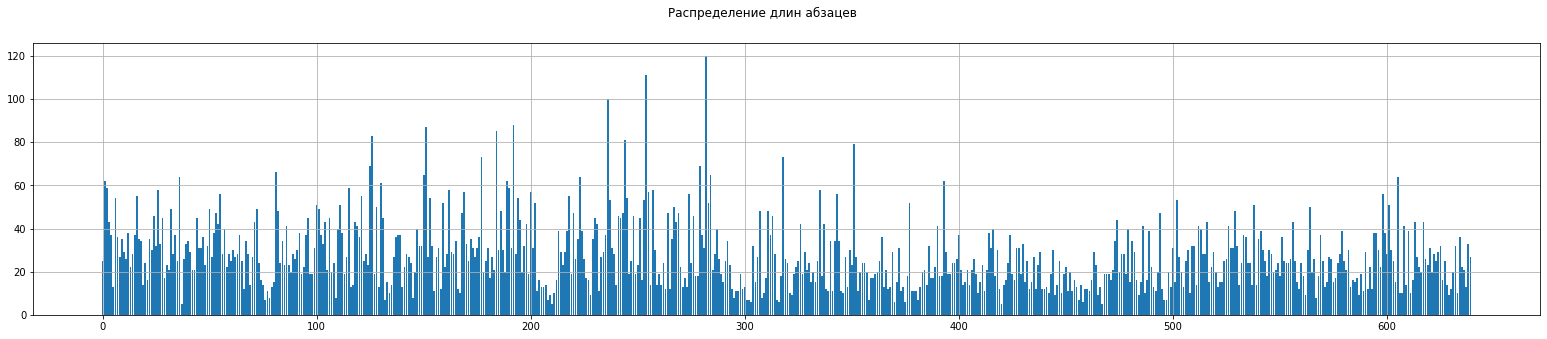

Collections Counter({19: 27, 13: 25, 25: 24, 28: 23, 14: 22, 24: 22, 15: 22, 20: 22, 12: 21, 27: 20, 11: 20, 31: 19, 21: 17, 16: 16, 30: 16, 37: 15, 29: 15, 22: 15, 10: 15, 26: 14, 32: 13, 23: 13, 18: 12, 34: 11, 17: 11, 7: 11, 43: 9, 36: 9, 9: 9, 35: 8, 38: 8, 45: 8, 47: 7, 40: 7, 41: 7, 39: 7, 33: 6, 8: 6, 46: 5, 42: 5, 48: 5, 6: 5, 54: 4, 58: 4, 49: 4, 5: 4, 56: 4, 51: 4, 52: 4, 62: 3, 59: 3, 55: 3, 64: 3, 50: 3, 57: 3, 53: 3, 69: 2, 65: 2, 73: 2, 44: 2, 66: 1, 83: 1, 61: 1, 87: 1, 85: 1, 88: 1, 100: 1, 81: 1, 111: 1, 120: 1, 79: 1})


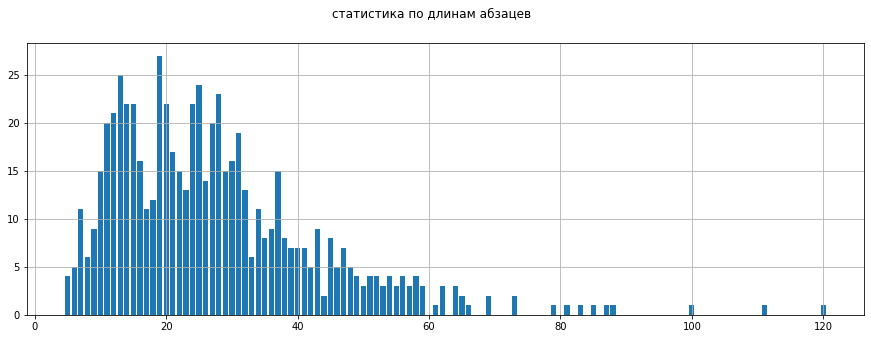

In [53]:
train_counter, train_count = draw_paragraphs_stat(paragraphs_train)

**Во скольких фразах встречается тот или  иной класс**

In [54]:
class_stat(paragraphs_train, tags_train)

Длина массива разметки текста: 640

Перечень фраз без неклассифицированных лексем:
paragraphs[37] = ['дракон-схема', '—', 'это', 'упорядоченная', 'блок-схема']
tags[37] = ['термин', 'связка', 'связка', 'определение', 'определение']
 
paragraphs[315] = ['орнаментика', '—', 'наука', 'о', 'способах', 'украшения', 'мелодий']
tags[315] = ['термин', 'связка', 'определение', 'определение', 'определение', 'определение', 'определение']
 
paragraphs[316] = ['мелизматика', '—', 'учение', 'об', 'украшении', 'мелодии']
tags[316] = ['термин', 'связка', 'определение', 'определение', 'определение', 'определение']
 
paragraphs[630] = ['keras', '—', 'рекомендуемая', 'библиотека', 'для', 'глубокого', 'изучения', 'python', ',', 'особенно', 'для', 'начинающих']
tags[630] = ['термин', 'связка', 'определение', 'определение', 'определение', 'определение', 'определение', 'определение', 'определение', 'определение', 'определение', 'определение']
 

Статистика по классам
Фраз без определительных структур: 22.0
Ф

### Тестовая выборка

In [57]:
test_paragraphs_amount = 160
ps_test = load_xml('/content/drive/My Drive/Базы/NLP/База_словарей_test_2.xml', test_paragraphs_amount)
print(len(ps_test))

169


In [58]:
paragraphs_test, tags_test, test_colors, max_test_paragraph_len, max_test_paragraph_len_ind  = pars_xml(ps_test)

line 0
line 100


In [59]:
if len(test_colors) > colors_count:
  print('В документе цветов разметки больше допустимого')
test_colors # выведем все цвета, которые мы встретили

{'blue',
 'cyan',
 'darkyellow',
 'green',
 'lightgray',
 'magenta',
 'red',
 'white',
 'yellow'}

In [60]:
print(len(paragraphs_test))
print(len(tags_test))

print('Максимальная длина предложения — max_test_paragraph_len =',max_test_paragraph_len)
print('Индекс предложения с максимальной длиной — max_test_paragraph_len_ind =',max_test_paragraph_len_ind)

160
160
Максимальная длина предложения — max_test_paragraph_len = 88
Индекс предложения с максимальной длиной — max_test_paragraph_len_ind = 64


In [61]:
# Корректируем максимальную длину предложения для использования U-net сеток
max_test_paragraph_len = max_paragraph_len

**Извлекаем статистику по абзацам**

In [62]:
paragraphs_test[0]

['удобный',
 'поиск',
 '—',
 'возможность',
 'использования',
 'эффективной',
 'системы',
 'поиска',
 '(',
 'полнотекстовый',
 'поиск',
 ',',
 'одновременный',
 'поиск',
 'в',
 'нескольких',
 'словарях',
 ',',
 'высокая',
 'скорость',
 'поиска',
 ')',
 '.']

In [63]:
tags_test[0]

['термин',
 'термин',
 'связка',
 'определение',
 'определение',
 'определение',
 'определение',
 'определение',
 'o',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'o',
 'o']

In [64]:
paragraphs_test[test_paragraphs_amount - 1]

['matplotlib',
 '—',
 'самая',
 'полная',
 'библиотека',
 'визуализации',
 'данных',
 'для',
 'python',
 '.']

In [65]:
tags_test[test_paragraphs_amount - 1]

['термин',
 'связка',
 'определение',
 'определение',
 'определение',
 'определение',
 'определение',
 'определение',
 'определение',
 'o']

In [66]:
paragraphs_test[max_test_paragraph_len_ind]

['падеж',
 'в',
 'языках',
 'флективного',
 '(',
 'синтетического',
 ')',
 'или',
 'агглютинативного',
 'строя',
 '—',
 'словоизменительная',
 'грамматическая',
 'категория',
 'именных',
 'и',
 'местоимённых',
 'частей',
 'речи',
 '(',
 'существительных',
 ',',
 'прилагательных',
 ',',
 'числительных',
 ')',
 'и',
 'близких',
 'к',
 'ним',
 'гибридных',
 'частей',
 'речи',
 '(',
 'причастий',
 ',',
 'герундиев',
 ',',
 'инфинитивов',
 'и',
 'проч',
 '.',
 ')',
 ',',
 'выражающая',
 'их',
 'синтаксическую',
 'и',
 '/',
 'или',
 'семантическую',
 'роль',
 'в',
 'предложении',
 '.',
 'падеж',
 'является',
 'одним',
 'из',
 'средств',
 'выражения',
 'синтаксической',
 'зависимости',
 'имени',
 ',',
 'выражаемым',
 'при',
 'подчиненном',
 'имени',
 '(',
 'ср',
 '.',
 'с',
 'маркерами',
 'изафета',
 '—',
 'показателями',
 'наличия',
 'зависимого',
 'синтаксического',
 'элемента',
 ',',
 'присоединяемыми',
 'к',
 'синтаксическим',
 'вершинам',
 ')',
 '.']

In [67]:
tags_test[max_test_paragraph_len_ind]

['термин',
 'связка',
 'связка',
 'связка',
 'связка',
 'связка',
 'связка',
 'связка',
 'связка',
 'связка',
 'связка',
 'определение',
 'определение',
 'определение',
 'определение',
 'определение',
 'определение',
 'определение',
 'определение',
 'определение',
 'определение',
 'определение',
 'определение',
 'определение',
 'определение',
 'определение',
 'определение',
 'определение',
 'определение',
 'определение',
 'определение',
 'определение',
 'определение',
 'определение',
 'определение',
 'определение',
 'определение',
 'определение',
 'определение',
 'определение',
 'определение',
 'определение',
 'определение',
 'o',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'расшифровка',
 'o',
 'дубль-термин',
 'дубль-связка',
 'дубль-определение',
 'дубль-определение',
 'дубль-определение',
 'дубль-определение',
 'дубль-определение',
 'дубль-определение',
 'дубль-определение',
 'o',
 

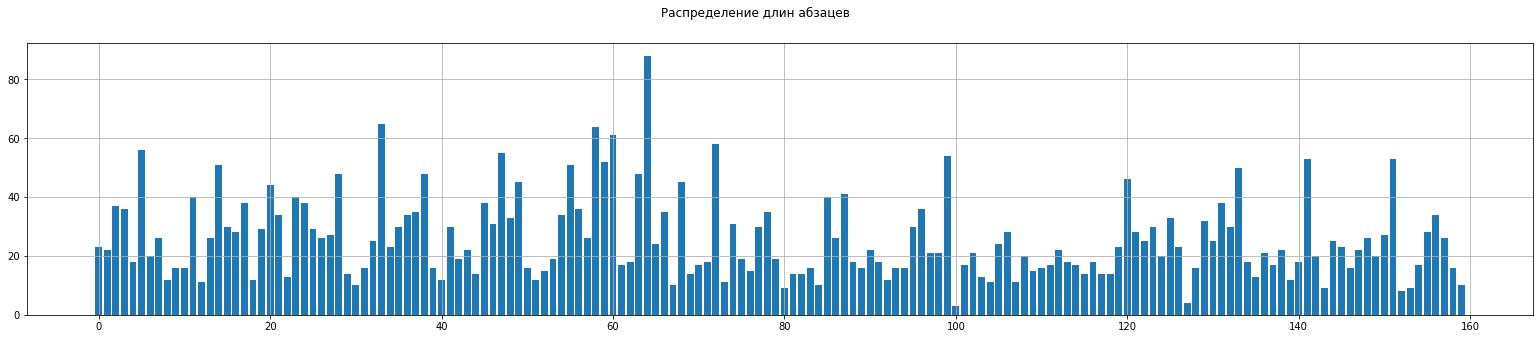

Collections Counter({19: 27, 13: 25, 25: 24, 28: 23, 14: 22, 24: 22, 15: 22, 20: 22, 12: 21, 27: 20, 11: 20, 31: 19, 21: 17, 16: 16, 30: 16, 37: 15, 29: 15, 22: 15, 10: 15, 26: 14, 32: 13, 23: 13, 18: 12, 34: 11, 17: 11, 7: 11, 43: 9, 36: 9, 9: 9, 35: 8, 38: 8, 45: 8, 47: 7, 40: 7, 41: 7, 39: 7, 33: 6, 8: 6, 46: 5, 42: 5, 48: 5, 6: 5, 54: 4, 58: 4, 49: 4, 5: 4, 56: 4, 51: 4, 52: 4, 62: 3, 59: 3, 55: 3, 64: 3, 50: 3, 57: 3, 53: 3, 69: 2, 65: 2, 73: 2, 44: 2, 66: 1, 83: 1, 61: 1, 87: 1, 85: 1, 88: 1, 100: 1, 81: 1, 111: 1, 120: 1, 79: 1})


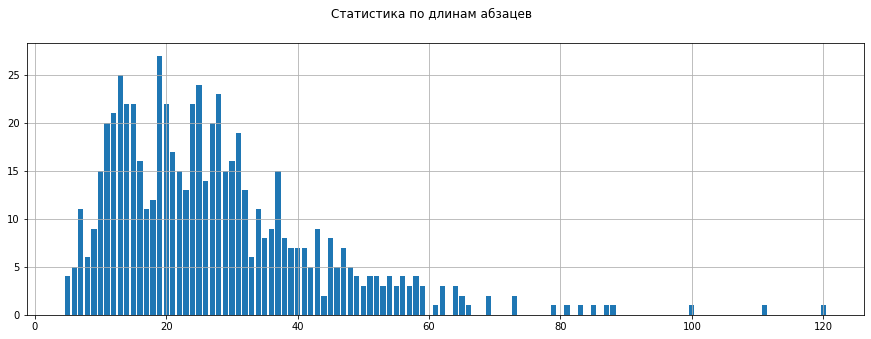

In [70]:
test_counter, test_count = draw_paragraphs_stat(paragraphs_test)

**Во скольких фразах встречается тот или  иной класс**

In [71]:
class_stat(paragraphs_test, tags_test)

Длина массива разметки текста: 160

Перечень фраз без неклассифицированных лексем:
paragraphs[100] = ['seaborn', '—', 'это']
tags[100] = ['термин', 'связка', 'связка']
 

Статистика по классам
Фраз без определительных структур: 2.0
Фраз с категорией термин: 155.0
Фраз с категорией связка: 152.0
Фраз с категорией определение: 151.0
Фраз с категорией расшифровка: 101.0
Фраз с категорией дубль-термин: 42.0
Фраз с категорией дубль-связка: 34.0
Фраз с категорией дубль-определение: 38.0
Фраз с категорией дубль-расшифровка: 12.0


## Подготовка датасета

Объединим обучающий и тестовый массивы, чтобы воспользоваться общим токенизатором над редкими словами.

In [115]:
all_paragraphs = paragraphs_train + paragraphs_test
all_tags = tags_train + tags_test
print(len(all_paragraphs))
print(len(all_tags))

800
800


In [116]:
all_paragraphs_together = [' '.join(sequence) for sequence in all_paragraphs]

In [117]:
all_paragraphs_together[max_paragraph_len_ind]

'существительное называет предметы в широком смысле слова ; это — названия вещей ( стол , стена , окно , ножницы , сани ) , лиц ( ребёнок , девочка , юноша , человек ) , веществ ( крупа , сахар , сливки , кислота ) , живых существ и организмов ( кошка , собака , ворона , дятел , окунь , щука , бактерия , вирус , микроб ) , фактов , событий , явлений ( пожар , спектакль , беседа , каникулы , радость ) , географические положения ( россия , байкал , оренбург , европа ) , а также качеств , свойств , действий , состояний ( доброта , синева , бег , решение , толкотня ) .'

In [118]:
all_tags_together = [' '.join(tag) for tag in all_tags]

In [119]:
all_tags_together[max_paragraph_len_ind]

'термин o o o o o o o связка связка определение определение o расшифровка расшифровка расшифровка расшифровка расшифровка расшифровка расшифровка расшифровка расшифровка o o определение o расшифровка расшифровка расшифровка расшифровка расшифровка расшифровка расшифровка o o определение o расшифровка расшифровка расшифровка расшифровка расшифровка расшифровка расшифровка o o определение определение определение определение o расшифровка расшифровка расшифровка расшифровка расшифровка расшифровка расшифровка расшифровка расшифровка расшифровка расшифровка расшифровка расшифровка расшифровка расшифровка расшифровка расшифровка o o определение определение определение определение определение o расшифровка расшифровка расшифровка расшифровка расшифровка расшифровка расшифровка расшифровка расшифровка o o определение определение o расшифровка расшифровка расшифровка расшифровка расшифровка расшифровка расшифровка o o o o определение определение определение определение определение определение 

In [120]:
num_words = 6250
sent_len = max_paragraph_len 
tokenizer = Tokenizer(num_words, filters=' \t\n', oov_token='<UNK>')

In [121]:
tokenizer.fit_on_texts(all_paragraphs_together)

In [122]:
# реальная длина словаря
len(tokenizer.index_word)

6204

In [ ]:
tokenizer.index_word

In [124]:
tokenizer.index_word[2]

','

In [125]:
tag_tokenizer = Tokenizer(filters=' ') # colors_count - количество категорий - лучше не указывать, чтобы не потерять категории. Все они автоматически подцедпляются под своими индексами

In [126]:
tag_tokenizer.fit_on_texts(all_tags_together)

In [127]:
tag_tokenizer.index_word # Здесь обращаем внимание, что фактическая нумерация индексов смещена на единицу по сравнению с массивом color_dic

{1: 'o',
 2: 'расшифровка',
 3: 'определение',
 4: 'связка',
 5: 'термин',
 6: 'дубль-определение',
 7: 'дубль-расшифровка',
 8: 'дубль-термин',
 9: 'дубль-связка'}

In [128]:
tag_tokenizer.word_index

{'o': 1,
 'дубль-определение': 6,
 'дубль-расшифровка': 7,
 'дубль-связка': 9,
 'дубль-термин': 8,
 'определение': 3,
 'расшифровка': 2,
 'связка': 4,
 'термин': 5}

In [129]:
len(tag_tokenizer.index_word) # эта величина равна colors_count

9

**Проверка входящих и исходящих массивов на соответствие их размерностей** 

(для выявления факта порчи данных функцией Tokenizer)

In [130]:
X = tokenizer.texts_to_sequences(all_paragraphs_together)

In [131]:
Y = tag_tokenizer.texts_to_sequences(all_tags_together)

In [132]:
len(X)==len(Y)

True

In [ ]:
# Проверка на согласованность входных и выходных данных
for i, elem in enumerate(X):
  if len(Y[i]) != len(X[i]):
    print('X[{}] ='.format(i),X[i])
    print('Y[{}] ='.format(i),Y[i])
    # Если все массивы равны, то здесь  ничего не должно печататься
  else:
    print('len(X[{}]) ='.format(i),len(Y[i]))

**Выравнивание массивов до максимального размера абзаца**

In [134]:
X = pad_sequences(X, sent_len, padding='post', truncating='post') # заполнение в конце и обрезка с конца предложения

In [135]:
X.shape

(800, 128)

In [136]:
Y = pad_sequences(Y, sent_len, value=1, padding='post', truncating='post') # заполнение в конце и обрезка с конца предложения

In [137]:
Y.shape

(800, 128)

In [138]:
Y = to_categorical(Y, colors_count+1)  # см. лекцию "Занятие № 6 Углубленный курс по текстам" https://youtu.be/Nfw7ZY-WzS8?t=1533

In [ ]:
Y.shape

In [ ]:
Y = Y[:, :, 1:]  # см. лекцию "Занятие № 6 Углубленный курс по текстам" https://youtu.be/Nfw7ZY-WzS8?t=1533
Y.shape

In [ ]:
X[2]

In [ ]:
Y[2]

In [ ]:
Y[2][0]

In [ ]:
Y[2][29]

In [ ]:
X[16]

In [ ]:
for elem in Y[16]:
  print(elem)

In [148]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, train_size=train_paragraphs_len, shuffle=False) # Не перемешаем данные и возьмём целую часть на тренировочную выборку

### Итого по тренировочным и валидационным выборкам имеем:

In [149]:
print('Xtrain.shape=',Xtrain.shape)
print('Xtest.shape=',Xtest.shape)
print('Ytrain.shape=',Ytrain.shape)
print('Ytest.shape=',Ytest.shape)

Xtrain.shape= (640, 128)
Xtest.shape= (160, 128)
Ytrain.shape= (640, 128, 9)
Ytest.shape= (160, 128, 9)


In [ ]:
Xtest[0]

In [ ]:
Xtest[-1]

In [ ]:
print(len(Xtest[16]))
Xtest[16]

In [153]:
tokenizer.index_word[895]

'обозначающие'

In [ ]:
print(len(Ytest[16]))
for elem in Ytest[16]:
  print(elem)

## Модели

**Самописная функция разбивки предсказания по классам** (по аналогии с функцией **classification_report** из библиотеки sklearn)

In [155]:
def class_report(y_true, y_pred, index_word):     # Функция разбивки предсказания по классам
  true = np.argmax(y_true, axis = -1).flatten()   # Преобразуем в вектор токенов из ohe
  # print('true=', true)
  pred = np.argmax(y_pred, axis = -1).flatten()  
  # print('pred=', pred)
  for index, word in index_word.items():          # Проходим по всем классам
    index = int(index) -1
    if index in true:                             
      mask = pred == index                        # Ищем положительные предсказания
      # print('mask=',mask)
      # print('true[mask]=',true[mask])
      # print('pred[mask]=',pred[mask])
      # print('(true[mask] == pred[mask])=',(true[mask] == pred[mask]))
      middle = (true[mask] == pred[mask])
      if middle.any():
        acc = middle.mean()
      else:
        acc = 0
      print('{}  --- {}' .format(word, acc))
    else:
      print('no acc for', word)

In [156]:
emb_size = 128

In [157]:
'''
  Собственная функция метрики, обрабатывающая пересечение двух областей
'''
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.) # Возвращаем площадь пересечения деленную на площадь объединения двух областей

### **Линейная сегментирующая сеть**

В показаниях точности обучения нейронных сетех приведено по два значения — предыдущее и текущее значение. С момента предыдущего обучения увеличена обучающая база в два раза. В результате лучшая архитектура улучшила показатели на 3%, а худшая архитектура — на 5%, что сократило отличия в обучаемомсти разных архитектур нейронных сетей  с 5% до 2%.

### **Рекуррентная сеть GRU** - max 87% -> 92%

#### Алгоритм: Embedding + Bidirectional(GRU) + GRU , batch_size = 128, activation='softmax' - max 87% -> 92%

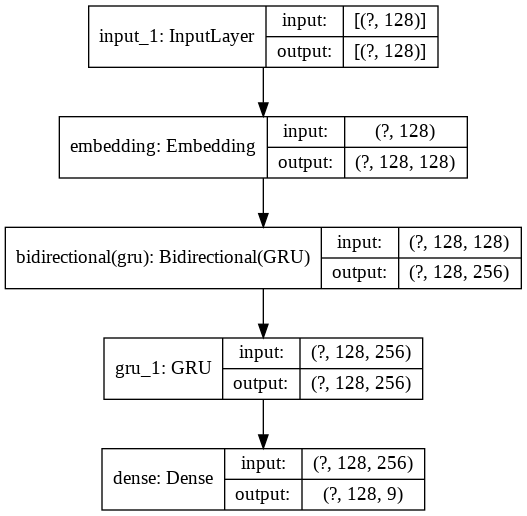

In [158]:
input = Input((sent_len,))
# input = Input(shape=(None,))
x = Embedding(num_words, emb_size)(input)
x = Bidirectional(GRU(emb_size, return_sequences=True))(x)
x = GRU(emb_size * 2, return_sequences=True)(x)
output = Dense(colors_count, activation='softmax')(x)

modelEGRU = Model(input, output)

modelEGRU.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[dice_coef])

plot_model(modelEGRU, show_shapes=True)

In [159]:
historyEGRU = modelEGRU.fit(Xtrain, 
                    Ytrain, 
                    epochs=100,
                    batch_size=128,
                    validation_data=(Xtest, Ytest)) # Обучаем модель на выборке по всем классам

Epoch 1/100
5/5 [==============================] - 1s 200ms/step - loss: 1.8033 - dice_coef: 0.1801 - val_loss: 0.8730 - val_dice_coef: 0.4853
Epoch 2/100
5/5 [==============================] - 0s 42ms/step - loss: 0.6081 - dice_coef: 0.7389 - val_loss: 0.6171 - val_dice_coef: 0.8449
Epoch 3/100
5/5 [==============================] - 0s 43ms/step - loss: 0.4874 - dice_coef: 0.8377 - val_loss: 0.4030 - val_dice_coef: 0.8351
Epoch 4/100
5/5 [==============================] - 0s 42ms/step - loss: 0.4160 - dice_coef: 0.8192 - val_loss: 0.4149 - val_dice_coef: 0.8275
Epoch 5/100
5/5 [==============================] - 0s 43ms/step - loss: 0.4231 - dice_coef: 0.8152 - val_loss: 0.4023 - val_dice_coef: 0.8312
Epoch 6/100
5/5 [==============================] - 0s 43ms/step - loss: 0.3935 - dice_coef: 0.8258 - val_loss: 0.3815 - val_dice_coef: 0.8395
Epoch 7/100
5/5 [==============================] - 0s 42ms/step - loss: 0.3671 - dice_coef: 0.8400 - val_loss: 0.3813 - val_dice_coef: 0.8456
Epoch

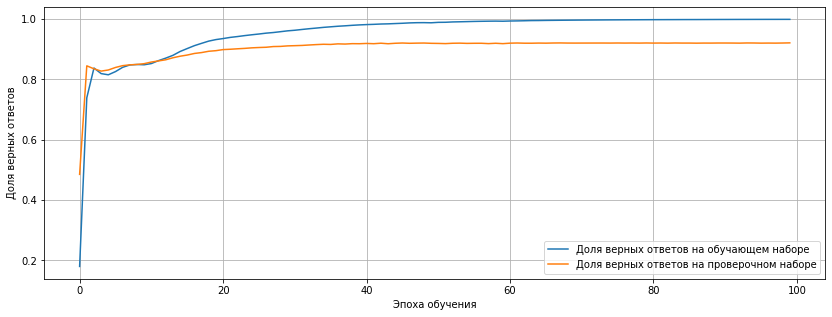

In [160]:
# Отобразим график обучения модели
plt.figure(figsize=(14, 5))
plt.plot(historyEGRU.history['dice_coef'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(historyEGRU.history['val_dice_coef'], 
         label='Доля верных ответов на проверочном наборе')
plt.grid(True)
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()


In [161]:
YpredEGRU = modelEGRU.predict(Xtest)

In [162]:
Xtest[16][:46]

array([  42,   23,  477,   36,  532, 5471,  241,    8, 2039,  335, 5472,
          2, 2039,  764, 5473,    2,  764, 5474,    5,    4,  241,    2,
        774,   10,  292,  126,   36,    3,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0], dtype=int32)

In [164]:
YpredEGRU[16][:46]

array([[9.89610434e-01, 3.67866154e-03, 6.07294729e-03, 6.90965462e-05,
        5.04987256e-04, 2.48749780e-06, 9.73169699e-06, 4.61575401e-05,
        5.54289181e-06],
       [8.35876986e-02, 7.56261468e-01, 1.58348992e-01, 1.46799150e-03,
        3.24847351e-04, 6.34217599e-07, 3.04758191e-06, 4.29400598e-06,
        9.47066496e-07],
       [9.97377276e-01, 2.52987118e-03, 8.98033759e-05, 7.65251329e-08,
        2.51945767e-06, 4.40711645e-09, 2.18439533e-09, 4.76528811e-07,
        2.83304793e-08],
       [1.57950923e-01, 6.77388787e-01, 1.17349781e-01, 4.01908047e-02,
        7.05963606e-03, 3.75240620e-06, 4.58876593e-06, 3.17724334e-05,
        1.99581027e-05],
       [8.46393414e-06, 4.26688651e-03, 2.03126222e-01, 7.90703535e-01,
        1.89408672e-03, 2.65337604e-07, 5.55680515e-08, 1.05053743e-07,
        4.22501500e-07],
       [1.71843159e-03, 5.58114436e-04, 9.94270802e-01, 5.18312037e-04,
        2.93178018e-03, 9.89758746e-07, 4.84607554e-09, 1.53848111e-06,
        5.3

In [165]:
YpredEGRU[16][:46]

array([[9.89610434e-01, 3.67866154e-03, 6.07294729e-03, 6.90965462e-05,
        5.04987256e-04, 2.48749780e-06, 9.73169699e-06, 4.61575401e-05,
        5.54289181e-06],
       [8.35876986e-02, 7.56261468e-01, 1.58348992e-01, 1.46799150e-03,
        3.24847351e-04, 6.34217599e-07, 3.04758191e-06, 4.29400598e-06,
        9.47066496e-07],
       [9.97377276e-01, 2.52987118e-03, 8.98033759e-05, 7.65251329e-08,
        2.51945767e-06, 4.40711645e-09, 2.18439533e-09, 4.76528811e-07,
        2.83304793e-08],
       [1.57950923e-01, 6.77388787e-01, 1.17349781e-01, 4.01908047e-02,
        7.05963606e-03, 3.75240620e-06, 4.58876593e-06, 3.17724334e-05,
        1.99581027e-05],
       [8.46393414e-06, 4.26688651e-03, 2.03126222e-01, 7.90703535e-01,
        1.89408672e-03, 2.65337604e-07, 5.55680515e-08, 1.05053743e-07,
        4.22501500e-07],
       [1.71843159e-03, 5.58114436e-04, 9.94270802e-01, 5.18312037e-04,
        2.93178018e-03, 9.89758746e-07, 4.84607554e-09, 1.53848111e-06,
        5.3

In [166]:
class_report(Ytest, YpredEGRU, tag_tokenizer.index_word)

o  --- 0.9684589452031312
расшифровка  --- 0.6148086522462562
определение  --- 0.5640552995391706
связка  --- 0.603448275862069
термин  --- 0.6501901140684411
дубль-определение  --- 0.5128205128205128
дубль-расшифровка  --- 0
дубль-термин  --- 0.5714285714285714
дубль-связка  --- 0.35714285714285715


In [167]:
# Встроенная функция sklearn возвращает и точность и полноту по классам
print(classification_report(Ytest.argmax(axis=-1).flatten(), YpredEGRU.argmax(axis=-1).flatten(), target_names=list(tag_tokenizer.index_word.values())))  

                   precision    recall  f1-score   support

                o       0.97      0.98      0.97     17361
      расшифровка       0.61      0.61      0.61      1211
      определение       0.56      0.69      0.62       886
           связка       0.60      0.73      0.66       287
           термин       0.65      0.64      0.65       266
дубль-определение       0.51      0.12      0.19       171
дубль-расшифровка       0.00      0.00      0.00       142
     дубль-термин       0.57      0.16      0.25        98
     дубль-связка       0.36      0.09      0.14        58

         accuracy                           0.91     20480
        macro avg       0.54      0.45      0.46     20480
     weighted avg       0.91      0.91      0.91     20480



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Алгоритм: Embedding + Bidirectional(GRU) + GRU + CRF , batch_size = 128 - max 87% -> X

In [171]:
crf = CRF()

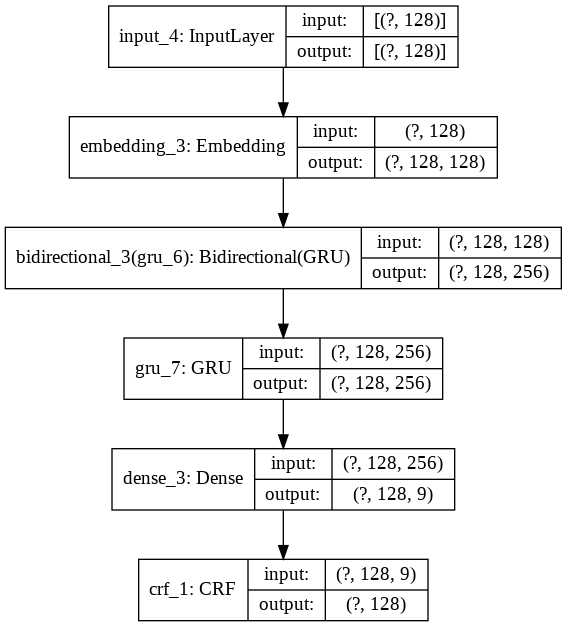

In [173]:
input = Input((sent_len,))
# input = Input(shape=(None,))
x = Embedding(num_words, emb_size)(input)
x = Bidirectional(GRU(emb_size, return_sequences=True))(x)
x = GRU(emb_size * 2, return_sequences=True)(x)
x = Dense(colors_count)(x)
output = crf(x)

modelCRF = Model(input, output)

modelCRF.compile(loss=crf.loss, optimizer='adam', metrics=[dice_coef])

plot_model(modelCRF, show_shapes=True)

Здесь что-то сломало output удалив последнюю мерность в тензоре (None, 128, 9)

In [174]:
historyCRF = modelCRF.fit(Xtrain, 
                    Ytrain, 
                    epochs=100,
                    batch_size=128,
                    validation_data=(Xtest, Ytest)) # Обучаем модель на выборке по всем классам

Epoch 1/100
5/5 [==============================] - ETA: 0s - loss: 262.0579 - dice_coef: 1.9734

ValueError: ignored

In [ ]:
# Отобразим график обучения модели
plt.figure(figsize=(14, 5))
# даёт сильно отрицательные результаты
# plt.plot(historyCRF.history['dice_coef'], 
#          label='Доля верных ответов на обучающем наборе')
plt.plot(historyCRF.history['val_dice_coef'], 
         label='Доля верных ответов на проверочном наборе')
plt.grid(True)
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()


In [ ]:
YpredCRF = modelCRF.predict(Xtest)

In [ ]:
class_report(Ytest, YpredCRF, tag_tokenizer.index_word)

In [ ]:
# Встроенная функция sklearn возвращает и точность и полноту по классам
print(classification_report(Ytest.argmax(axis=-1).flatten(), YpredCRF.argmax(axis=-1).flatten(), target_names=list(tag_tokenizer.index_word.values())))  

### **Одномерная свёртка** - max 85% -> 90%

#### Алгоритм: Embedding + Conv1D , batch_size = 16, activation='softmax' - max 85% -> 90%

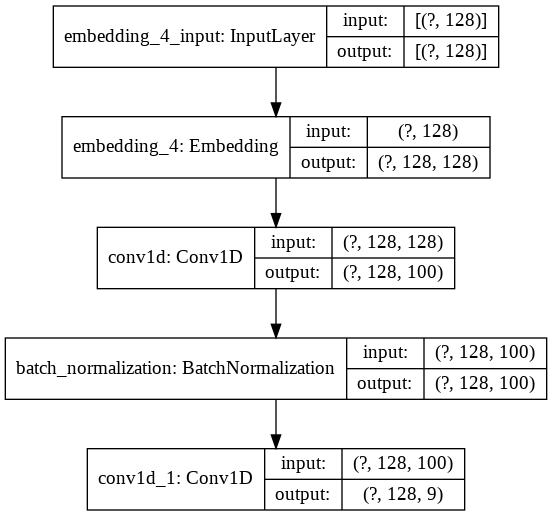

In [175]:
#Создаём сеть с Embedding слоем
modelEC = Sequential()
modelEC.add(Embedding(num_words, emb_size, input_length=sent_len))

modelEC.add(Conv1D(100, 3, activation='relu', padding='same')) #добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров 

modelEC.add(BatchNormalization())
modelEC.add(Conv1D(colors_count,3, activation='softmax', padding='same'))

# optimizer='adam'
modelEC.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=[dice_coef])

plot_model(modelEC, show_shapes=True)

In [176]:

#Обучаем сеть
historyEC = modelEC.fit(Xtrain, 
                    Ytrain, 
                    epochs=100,
                    batch_size=16,
                    validation_data=(Xtest, Ytest))



Epoch 1/100
40/40 [==============================] - 0s 10ms/step - loss: 1.0808 - dice_coef: 0.6272 - val_loss: 1.2070 - val_dice_coef: 0.3226
Epoch 2/100
40/40 [==============================] - 0s 6ms/step - loss: 0.5439 - dice_coef: 0.8326 - val_loss: 0.8623 - val_dice_coef: 0.4846
Epoch 3/100
40/40 [==============================] - 0s 6ms/step - loss: 0.2971 - dice_coef: 0.8913 - val_loss: 0.6155 - val_dice_coef: 0.6988
Epoch 4/100
40/40 [==============================] - 0s 6ms/step - loss: 0.1700 - dice_coef: 0.9307 - val_loss: 0.5983 - val_dice_coef: 0.7942
Epoch 5/100
40/40 [==============================] - 0s 6ms/step - loss: 0.0978 - dice_coef: 0.9554 - val_loss: 0.6575 - val_dice_coef: 0.8281
Epoch 6/100
40/40 [==============================] - 0s 6ms/step - loss: 0.0542 - dice_coef: 0.9725 - val_loss: 0.7150 - val_dice_coef: 0.8388
Epoch 7/100
40/40 [==============================] - 0s 6ms/step - loss: 0.0333 - dice_coef: 0.9822 - val_loss: 0.7264 - val_dice_coef: 0.845

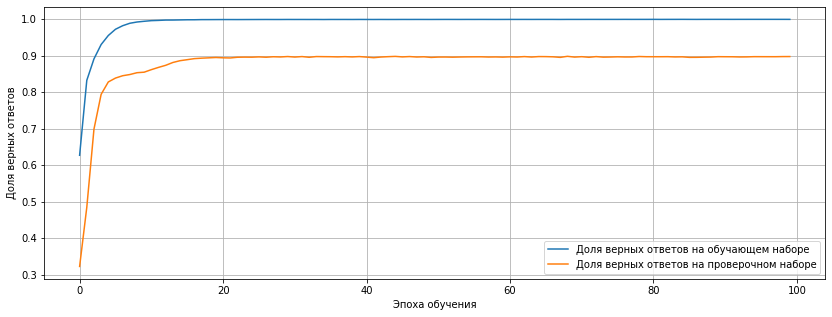

In [177]:
# Отобразим график обучения модели
plt.figure(figsize=(14, 5))
plt.plot(historyEC.history['dice_coef'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(historyEC.history['val_dice_coef'], 
         label='Доля верных ответов на проверочном наборе')
plt.grid(True)
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [178]:
YpredEC = modelEC.predict(Xtest)

In [179]:
class_report(Ytest, YpredEC, tag_tokenizer.index_word)

o  --- 0.9596359319351009
расшифровка  --- 0.5236656596173213
определение  --- 0.4959266802443992
связка  --- 0.7019867549668874
термин  --- 0.7110091743119266
дубль-определение  --- 0.16831683168316833
дубль-расшифровка  --- 0.05063291139240506
дубль-термин  --- 0.4576271186440678
дубль-связка  --- 0.22807017543859648


In [180]:
# Встроенная функция sklearn возвращает и точность и полноту по классам
print(classification_report(Ytest.argmax(axis=-1).flatten(), YpredEC.argmax(axis=-1).flatten(), target_names=list(tag_tokenizer.index_word.values())))  

                   precision    recall  f1-score   support

                o       0.96      0.98      0.97     17361
      расшифровка       0.52      0.43      0.47      1211
      определение       0.50      0.55      0.52       886
           связка       0.70      0.74      0.72       287
           термин       0.71      0.58      0.64       266
дубль-определение       0.17      0.10      0.12       171
дубль-расшифровка       0.05      0.03      0.04       142
     дубль-термин       0.46      0.28      0.34        98
     дубль-связка       0.23      0.22      0.23        58

         accuracy                           0.90     20480
        macro avg       0.48      0.43      0.45     20480
     weighted avg       0.89      0.90      0.89     20480



#### Оборачиваем алгоритм в функцию: **linearSegmentationNet**  - max 85% -> 90%

In [181]:
'''
  Функция создания сети
    Входные параметры:
    - num_classes - количество классов
    - sentence_len - длина предложения
    - num_words - количество слов в словаре
    - embedding_size - длина эмбединга
'''
def linearSegmentationNet(
      num_classes = 9,
      sentence_len = 200,
      num_words = 5000,
      activation_function = 'softmax',
      embedding_size = 500
      ):
    input = Input((sentence_len,))                                          # Создаем входной слой с размерностью input_shape
    emb = Embedding(num_words, embedding_size)(input)
    x = Conv1D(64, 3, padding='same', name='block1_conv1')(emb) # Добавляем Conv1D-слой с 128-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv1D(128, 5, padding='same', name='block1_conv2')(x)         # Добавляем Conv1D-слой с 128-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv1D(num_classes,3, activation=activation_function, padding='same')(x) # Добавляем Conv1D-Слой с softmax-активацией на num_classes-нейронов

    model = Model(input, x)                                             # Создаем модель с входом 'input' и выходом 'x'

    # Компилируем модель
    model.compile(optimizer=Adam(lr=1e-3),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    return model # Возвращаем сформированную модель

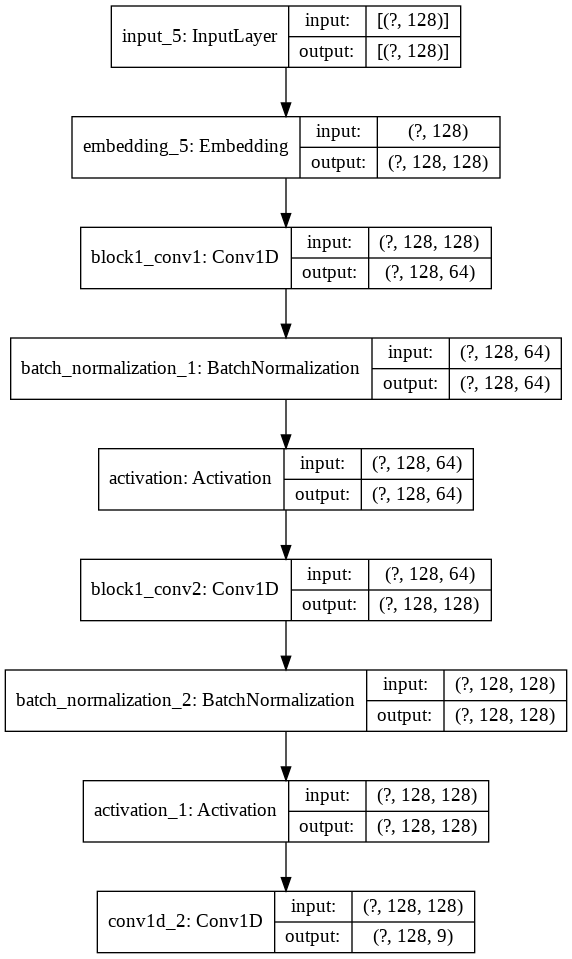

In [182]:
modelL = linearSegmentationNet(colors_count, sent_len, num_words, 'softmax', emb_size) # Создаем модель linearSegmentationNet
plot_model(modelL, show_shapes=True)

In [183]:
historyL = modelL.fit(Xtrain, 
                    Ytrain, 
                    epochs=100,
                    batch_size=16,
                    validation_data=(Xtest, Ytest)) # Обучаем модель на выборке по всем классам

Epoch 1/100
40/40 [==============================] - 0s 11ms/step - loss: 0.8068 - dice_coef: 0.6126 - val_loss: 0.9871 - val_dice_coef: 0.4221
Epoch 2/100
40/40 [==============================] - 0s 8ms/step - loss: 0.2286 - dice_coef: 0.8804 - val_loss: 0.7438 - val_dice_coef: 0.5629
Epoch 3/100
40/40 [==============================] - 0s 8ms/step - loss: 0.1045 - dice_coef: 0.9371 - val_loss: 0.6479 - val_dice_coef: 0.6348
Epoch 4/100
40/40 [==============================] - 0s 8ms/step - loss: 0.0399 - dice_coef: 0.9712 - val_loss: 0.5695 - val_dice_coef: 0.7023
Epoch 5/100
40/40 [==============================] - 0s 8ms/step - loss: 0.0189 - dice_coef: 0.9846 - val_loss: 0.5352 - val_dice_coef: 0.7403
Epoch 6/100
40/40 [==============================] - 0s 8ms/step - loss: 0.0115 - dice_coef: 0.9900 - val_loss: 0.4942 - val_dice_coef: 0.7757
Epoch 7/100
40/40 [==============================] - 0s 8ms/step - loss: 0.0069 - dice_coef: 0.9938 - val_loss: 0.4762 - val_dice_coef: 0.795

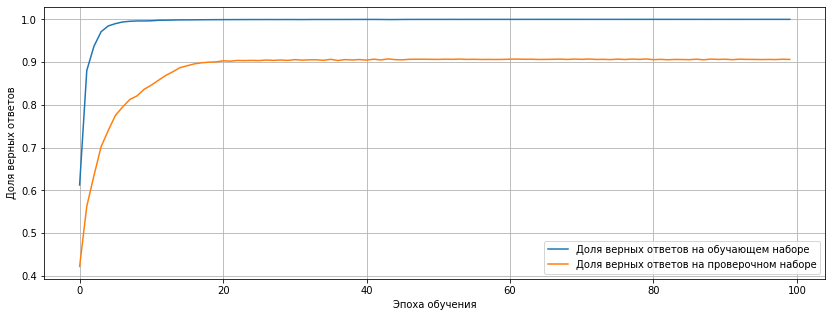

In [184]:
# Отобразим график обучения модели
plt.figure(figsize=(14, 5))
plt.plot(historyL.history['dice_coef'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(historyL.history['val_dice_coef'], 
         label='Доля верных ответов на проверочном наборе')
plt.grid(True)
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [185]:
YpredL = modelL.predict(Xtest)

In [186]:
class_report(Ytest, YpredL, tag_tokenizer.index_word)

o  --- 0.9658658488101324
расшифровка  --- 0.5609137055837563
определение  --- 0.5735632183908046
связка  --- 0.7009966777408638
термин  --- 0.7471264367816092
дубль-определение  --- 0.1875
дубль-расшифровка  --- 0.07228915662650602
дубль-термин  --- 0.4107142857142857
дубль-связка  --- 0.3


In [187]:
# Встроенная функция sklearn возвращает и точность и полноту по классам
print(classification_report(Ytest.argmax(axis=-1).flatten(), YpredL.argmax(axis=-1).flatten(), target_names=list(tag_tokenizer.index_word.values())))  

                   precision    recall  f1-score   support

                o       0.97      0.98      0.97     17361
      расшифровка       0.56      0.55      0.55      1211
      определение       0.57      0.56      0.57       886
           связка       0.70      0.74      0.72       287
           термин       0.75      0.73      0.74       266
дубль-определение       0.19      0.09      0.12       171
дубль-расшифровка       0.07      0.04      0.05       142
     дубль-термин       0.41      0.23      0.30        98
     дубль-связка       0.30      0.21      0.24        58

         accuracy                           0.91     20480
        macro avg       0.50      0.46      0.47     20480
     weighted avg       0.90      0.91      0.91     20480



### **U-net** - max 89% -> 92%

In [189]:
'''
  Функция создания сети
    Входные параметры:
    - num_classes - количество классов
    - sentence_len - длина предложения
    - num_words - количество слов в словаре
    - embedding_size - длина эмбединга
'''

def unet(
      num_classes = 6,
      sentence_len = 200,
      num_words = 5000,
      activation_function = 'softmax',
      embedding_size = 50
      ):
    print('num_classes=',num_classes)
    print('sentence_len=',sentence_len)
    print('num_words=',num_words)
    print('embedding_size=',embedding_size)

    txt_input = Input((sentence_len,))                                         # Создаем входной слой с размерностью input_shape
    print('txt_input=',txt_input.shape)
    emb = Embedding(num_words, embedding_size)(txt_input)
    print('emb=',emb.shape)

    # Block 1
    x = Conv1D(64, 3, padding='same', name='block1_conv1')(emb) # Добавляем Conv1D-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv1D(64, 3, padding='same', name='block1_conv2')(x)         # Добавляем Conv1D-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_1_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_1_out

    x = MaxPooling1D()(block_1_out)                                        # Добавляем слой MaxPooling1D

    # Block 2
    x = Conv1D(128, 3, padding='same', name='block2_conv1')(x)        # Добавляем Conv1D-слой с 128-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv1D(128, 3, padding='same', name='block2_conv2')(x)        # Добавляем Conv1D-слой с 128-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_2_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_2_out

    x = MaxPooling1D()(block_2_out)                                        # Добавляем слой MaxPooling1D

    # Block 3
    x = Conv1D(256, 3, padding='same', name='block3_conv1')(x)        # Добавляем Conv1D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv1D(256, 3, padding='same', name='block3_conv2')(x)        # Добавляем Conv1D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv1D(256, 3, padding='same', name='block3_conv3')(x)        # Добавляем Conv1D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_3_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_3_out

    x = MaxPooling1D()(block_3_out)                                        # Добавляем слой MaxPooling1D

    # Block 4
    x = Conv1D(512, 3, padding='same', name='block4_conv1')(x)        # Добавляем Conv1D-слой с 512-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv1D(512, 3, padding='same', name='block4_conv2')(x)        # Добавляем Conv1D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv1D(512, 3, padding='same', name='block4_conv3')(x)        # Добавляем Conv1D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_4_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_4_out
    x = block_4_out 

    # UP 2
    # x = Conv1DTranspose(x, 256, 2, strides=2, padding='same')(x)    # Добавляем слой Conv1DTranspose с 256 нейронами
    x = Lambda(lambda x: K.expand_dims(x, axis=2))(x)
    x = Conv2DTranspose(256, (2, 1), strides=(2, 1), padding='same')(x)
    x = Lambda(lambda x: K.squeeze(x, axis=2))(x)
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = concatenate([x, block_3_out])                                      # Объединем текущий слой со слоем block_3_out
    x = Conv1D(256, 3, padding='same')(x)                             # Добавляем слой Conv1D с 256 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv1D(256, 3, padding='same')(x)
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    # UP 3
    # x = Conv1DTranspose(x, 128, 2, strides=2, padding='same')(x)    # Добавляем слой Conv1DTranspose с 128 нейронами
    x = Lambda(lambda x: K.expand_dims(x, axis=2))(x)
    x = Conv2DTranspose(128, (2, 1), strides=(2, 1), padding='same')(x)
    x = Lambda(lambda x: K.squeeze(x, axis=2))(x)
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = concatenate([x, block_2_out])                                      # Объединем текущий слой со слоем block_2_out
    x = Conv1D(128, 3, padding='same')(x)                             # Добавляем слой Conv1D с 128 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv1D(128, 3, padding='same')(x) # Добавляем слой Conv1D с 128 нейронами
    x = BatchNormalization()(x) # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    # UP 4
    # x = Conv1DTranspose(x, 64, 2, strides=2, padding='same')(x)    # Добавляем слой Conv1DTranspose с 64 нейронами
    x = Lambda(lambda x: K.expand_dims(x, axis=2))(x)
    x = Conv2DTranspose(64, (2, 1), strides=(2, 1), padding='same')(x)
    x = Lambda(lambda x: K.squeeze(x, axis=2))(x)
    x = BatchNormalization()(x) # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    x = concatenate([x, block_1_out])  # Объединем текущий слой со слоем block_1_out
    x = Conv1D(64, 3, padding='same')(x) # Добавляем слой Conv1D с 64 нейронами
    x = BatchNormalization()(x) # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    x = Conv1D(64, 3, padding='same')(x) # Добавляем слой Conv1D с 64 нейронами
    x = BatchNormalization()(x) # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    x = Conv1D(num_classes, 3, activation='softmax', padding='same')(x)  # Добавляем Conv1D-Слой с softmax-активацией на num_classes-нейронов

    model = Model(txt_input, x) # Создаем модель с входом 'txt_input' и выходом 'x'

    # Компилируем модель 
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    
    return model # Возвращаем сформированную модель

num_classes= 9
sentence_len= 128
num_words= 6250
embedding_size= 128
txt_input= (None, 128)
emb= (None, 128, 128)


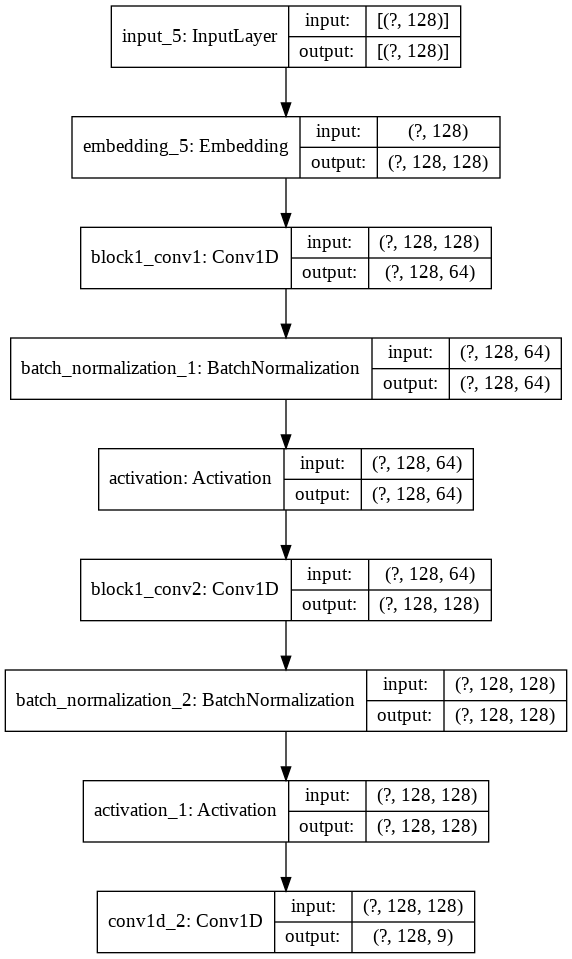

In [190]:
modelUnet = unet(colors_count, sent_len, num_words, 'softmax', emb_size) # Создаем модель unet
plot_model(modelL, show_shapes=True)


In [191]:
historyUnet = modelUnet.fit(Xtrain, 
                    Ytrain, 
                    epochs=100,
                    batch_size=16,
                    validation_data=(Xtest, Ytest)) # Обучаем модель на выборке по трем классам

Epoch 1/100
40/40 [==============================] - 1s 32ms/step - loss: 0.7529 - dice_coef: 0.6525 - val_loss: 1.0085 - val_dice_coef: 0.4309
Epoch 2/100
40/40 [==============================] - 1s 18ms/step - loss: 0.2329 - dice_coef: 0.8814 - val_loss: 0.7265 - val_dice_coef: 0.7290
Epoch 3/100
40/40 [==============================] - 1s 19ms/step - loss: 0.1486 - dice_coef: 0.9190 - val_loss: 0.7842 - val_dice_coef: 0.8037
Epoch 4/100
40/40 [==============================] - 1s 18ms/step - loss: 0.0938 - dice_coef: 0.9448 - val_loss: 0.8682 - val_dice_coef: 0.8289
Epoch 5/100
40/40 [==============================] - 1s 18ms/step - loss: 0.0519 - dice_coef: 0.9656 - val_loss: 0.9352 - val_dice_coef: 0.8383
Epoch 6/100
40/40 [==============================] - 1s 18ms/step - loss: 0.0320 - dice_coef: 0.9770 - val_loss: 0.9767 - val_dice_coef: 0.8422
Epoch 7/100
40/40 [==============================] - 1s 18ms/step - loss: 0.0177 - dice_coef: 0.9861 - val_loss: 0.9647 - val_dice_coef:

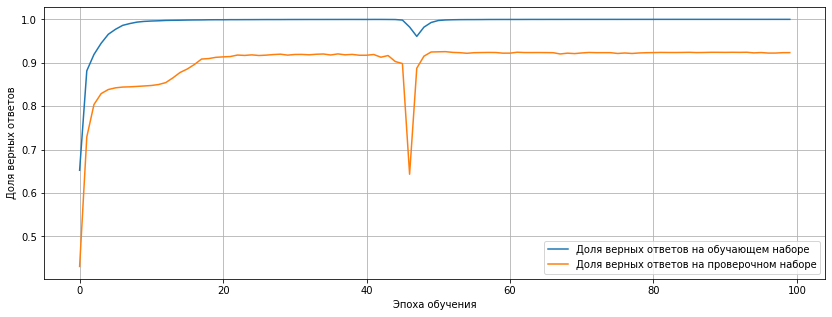

In [192]:
# Отобразим график обучения модели
plt.figure(figsize=(14, 5))
plt.plot(historyUnet.history['dice_coef'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(historyUnet.history['val_dice_coef'], 
         label='Доля верных ответов на проверочном наборе')
plt.grid(True)
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [194]:
YpredUnet = modelUnet.predict(Xtest)

In [195]:
class_report(Ytest, YpredUnet, tag_tokenizer.index_word)

o  --- 0.9710086916742909
расшифровка  --- 0.6521739130434783
определение  --- 0.6527777777777778
связка  --- 0.7889273356401384
термин  --- 0.8277310924369747
дубль-определение  --- 0.5686274509803921
дубль-расшифровка  --- 0.11538461538461539
дубль-термин  --- 0.5675675675675675
дубль-связка  --- 0.32786885245901637


In [196]:
# Встроенная функция sklearn возвращает и точность и полноту по классам
print(classification_report(Ytest.argmax(axis=-1).flatten(), YpredUnet.argmax(axis=-1).flatten(), target_names=list(tag_tokenizer.index_word.values())))  

                   precision    recall  f1-score   support

                o       0.97      0.98      0.97     17361
      расшифровка       0.65      0.66      0.65      1211
      определение       0.65      0.74      0.69       886
           связка       0.79      0.79      0.79       287
           термин       0.83      0.74      0.78       266
дубль-определение       0.57      0.17      0.26       171
дубль-расшифровка       0.12      0.04      0.06       142
     дубль-термин       0.57      0.43      0.49        98
     дубль-связка       0.33      0.34      0.34        58

         accuracy                           0.93     20480
        macro avg       0.61      0.54      0.56     20480
     weighted avg       0.92      0.93      0.92     20480



### **Упрощённая U-net** - max 87% -> 91%

In [197]:
def simpleUnet(
      num_classes = 9,
      sentence_len = 200,
      num_words = 5000,
      activation_function = 'softmax',
      embedding_size = 50
      ):
    print('num_classes=',num_classes)
    print('sentence_len=',sentence_len)
    print('num_words=',num_words)
    print('embedding_size=',embedding_size)

    txt_input = Input((sentence_len,))                                         # Создаем входной слой с размерностью input_shape
    print('txt_input=',txt_input.shape)
    emb = Embedding(num_words, embedding_size)(txt_input)
    print('emb=',emb.shape)

    # Block 1
    x = Conv1D(32, 3, padding='same', name='block1_conv1')(emb) # Добавляем Conv1D-слой с 32-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv1D(32, 3, padding='same', name='block1_conv2')(x)         # Добавляем Conv1D-слой с 32-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_1_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_1_out

    x = MaxPooling1D()(block_1_out)                                        # Добавляем слой MaxPooling1D

    # Block 2
    x = Conv1D(64, 3, padding='same', name='block2_conv1')(x)         # Добавляем Conv1D-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv1D(64, 3, padding='same', name='block2_conv2')(x)         # Добавляем Conv1D-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_2_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_2_out

    x = MaxPooling1D()(block_2_out)                                        # Добавляем слой MaxPooling1D
    
    # UP 1
    # x = Conv1DTranspose(x, 64, 2, strides=2, padding='same')(x)    # Добавляем слой Conv1DTranspose с 64 нейронами
    x = Lambda(lambda x: K.expand_dims(x, axis=2))(x)
    x = Conv2DTranspose(64, (2, 1), strides=(2, 1), padding='same')(x)
    x = Lambda(lambda x: K.squeeze(x, axis=2))(x)
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv1D(64, 3, padding='same')(x)                              # Добавляем Conv1D-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv1D(64, 3, padding='same')(x)                              # Добавляем Conv1D-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    # UP 2
    # x = Conv1DTranspose(x, 32, 2, strides=2, padding='same')(x)    # Добавляем слой Conv1DTranspose с 32 нейронами
    x = Lambda(lambda x: K.expand_dims(x, axis=2))(x)
    x = Conv2DTranspose(32, (2, 1), strides=(2, 1), padding='same')(x)
    x = Lambda(lambda x: K.squeeze(x, axis=2))(x)
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv1D(32, 3, padding='same')(x)                              # Добавляем Conv1D-слой с 32-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv1D(32, 3, padding='same')(x)                              # Добавляем Conv1D-слой с 32-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv1D(num_classes,3, activation=activation_function, padding='same')(x) # Добавляем Conv1D-Слой с softmax-активацией на num_classes-нейронов

    model = Model(txt_input, x)                                            # Создаем модель с входом 'txt_input' и выходом 'x'

    # Компилируем модель
    model.compile(optimizer=Adam(lr=1e-3),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    
    return model                                                           # Возвращаем модель

num_classes= 9
sentence_len= 128
num_words= 6250
embedding_size= 128
txt_input= (None, 128)
emb= (None, 128, 128)


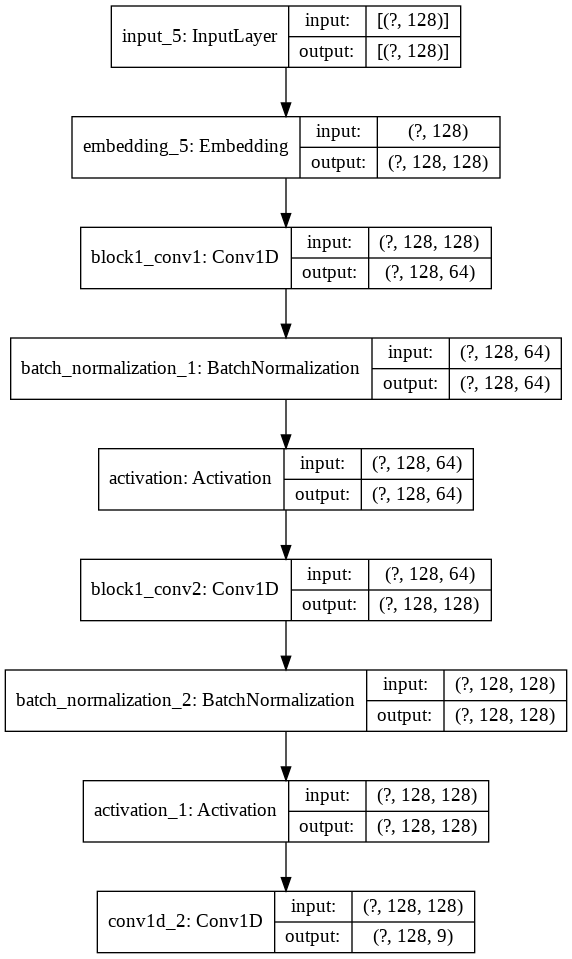

In [198]:
modelS = simpleUnet(colors_count, sent_len, num_words, 'softmax', emb_size) # Создаем модель simpleUnet
plot_model(modelL, show_shapes=True)

In [199]:
historyS = modelS.fit(Xtrain, 
                    Ytrain, 
                    epochs=100,
                    batch_size=16,
                    validation_data=(Xtest, Ytest)) # Обучаем модель на выборке по трем классам

Epoch 1/100
40/40 [==============================] - 1s 21ms/step - loss: 0.9631 - dice_coef: 0.5223 - val_loss: 1.4835 - val_dice_coef: 0.2411
Epoch 2/100
40/40 [==============================] - 0s 12ms/step - loss: 0.3537 - dice_coef: 0.8098 - val_loss: 0.8772 - val_dice_coef: 0.5253
Epoch 3/100
40/40 [==============================] - 0s 12ms/step - loss: 0.2408 - dice_coef: 0.8776 - val_loss: 0.7386 - val_dice_coef: 0.7262
Epoch 4/100
40/40 [==============================] - 1s 13ms/step - loss: 0.1965 - dice_coef: 0.9034 - val_loss: 0.8167 - val_dice_coef: 0.8079
Epoch 5/100
40/40 [==============================] - 0s 12ms/step - loss: 0.1755 - dice_coef: 0.9128 - val_loss: 0.9046 - val_dice_coef: 0.8274
Epoch 6/100
40/40 [==============================] - 0s 12ms/step - loss: 0.1467 - dice_coef: 0.9258 - val_loss: 1.0004 - val_dice_coef: 0.8379
Epoch 7/100
40/40 [==============================] - 0s 12ms/step - loss: 0.1325 - dice_coef: 0.9326 - val_loss: 1.0742 - val_dice_coef:

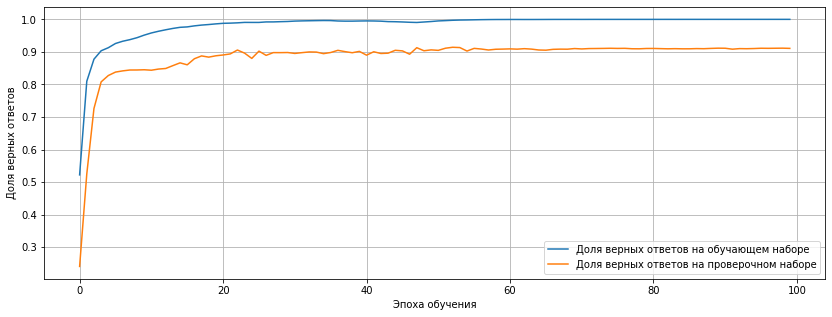

In [200]:
# Отобразим график обучения модели
plt.figure(figsize=(14, 5))
plt.plot(historyS.history['dice_coef'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(historyS.history['val_dice_coef'], 
         label='Доля верных ответов на проверочном наборе')
plt.grid(True)
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [201]:
YpredS = modelS.predict(Xtest)

In [202]:
class_report(Ytest, YpredS, tag_tokenizer.index_word)

o  --- 0.9580234392607617
расшифровка  --- 0.6206611570247934
определение  --- 0.7174177831912302
связка  --- 0.7592592592592593
термин  --- 0.745
дубль-определение  --- 0.2823529411764706
дубль-расшифровка  --- 0.09195402298850575
дубль-термин  --- 0.25287356321839083
дубль-связка  --- 0.34615384615384615


In [203]:
# Встроенная функция sklearn возвращает и точность и полноту по классам
print(classification_report(Ytest.argmax(axis=-1).flatten(), YpredS.argmax(axis=-1).flatten(), target_names=list(tag_tokenizer.index_word.values())))  

                   precision    recall  f1-score   support

                o       0.96      0.98      0.97     17361
      расшифровка       0.62      0.62      0.62      1211
      определение       0.72      0.66      0.69       886
           связка       0.76      0.57      0.65       287
           термин       0.74      0.56      0.64       266
дубль-определение       0.28      0.14      0.19       171
дубль-расшифровка       0.09      0.06      0.07       142
     дубль-термин       0.25      0.22      0.24        98
     дубль-связка       0.35      0.16      0.21        58

         accuracy                           0.91     20480
        macro avg       0.53      0.44      0.48     20480
     weighted avg       0.91      0.91      0.91     20480



### **Расширенная U-net** - max 84% -> 90%

In [205]:
def unetWithMask(
      num_classes = 9,
      sentence_len = 200,
      num_words = 5000,
      activation_function = 'softmax',
      embedding_size = 50
      ):
    print('num_classes=',num_classes)
    print('sentence_len=',sentence_len)
    print('num_words=',num_words)
    print('embedding_size=',embedding_size)

    txt_input = Input((sentence_len,))                                         # Создаем входной слой с размерностью input_shape
    print('txt_input=',txt_input.shape)
    emb = Embedding(num_words, embedding_size)(txt_input)
    print('emb=',emb.shape)

    # Block 1
    x = Conv1D(64, 3, padding='same', name='block1_conv1')(emb) # Добавляем Conv1D-слой с 64-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv1D(64, 3, padding='same', name='block1_conv2')(x)      # Добавляем Conv1D-слой с 64-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    block_1_out = Activation('relu')(x)                                 # Добавляем слой Activation и запоминаем в переменной block_1_out
    
    block_1_out_mask = Conv1D(64, 1, padding='same')(block_1_out)  # Добавляем Conv1D-маску к текущему слою и запоминаем в переменную block_1_out_mask

    x = MaxPooling1D()(block_1_out) # Добавляем слой MaxPooling1D

    # Block 2
    x = Conv1D(128, 3, padding='same', name='block2_conv1')(x)     # Добавляем Conv1D-слой с 128-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    x = Conv1D(128, 3, padding='same', name='block2_conv2')(x)     # Добавляем Conv1D-слой с 128-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    block_2_out = Activation('relu')(x)                                 # Добавляем слой Activation и запоминаем в переменной block_2_out

    block_2_out_mask = Conv1D(128, 1, padding='same')(block_2_out) # Добавляем Conv1D-маску к текущему слою и запоминаем в переменную block_2_out_mask
    
    x = MaxPooling1D()(block_2_out)                                     # Добавляем слой MaxPooling1D

    # Block 3
    x = Conv1D(256, 3, padding='same', name='block3_conv1')(x)     # Добавляем Conv1D-слой с 256-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv1D(256, 3, padding='same', name='block3_conv2')(x)     # Добавляем Conv1D-слой с 256-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv1D(256, 3, padding='same', name='block3_conv3')(x)     # Добавляем Conv1D-слой с 256-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    block_3_out = Activation('relu')(x)                                 # Добавляем слой Activation и запоминаем в переменной block_3_out

    block_3_out_mask = Conv1D(256, 1, padding='same')(block_3_out) # Добавляем Conv1D-маску к текущему слою и запоминаем в переменную block_3_out_mask
        
    x = MaxPooling1D()(block_3_out)                                     # Добавляем слой MaxPooling1D

     # Block 4
    x = Conv1D(512, 3, padding='same', name='block4_conv1')(x)     # Добавляем Conv1D-слой с 512-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv1D(512, 3, padding='same', name='block4_conv2')(x)     # Добавляем Conv1D-слой с 256-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv1D(512, 3, padding='same', name='block4_conv3')(x)     # Добавляем Conv1D-слой с 256-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    block_4_out = Activation('relu')(x)                                 # Добавляем слой Activation и запоминаем в переменной block_4_out

    block_4_out_mask = Conv1D(512, 1, padding='same')(block_4_out) # Добавляем Conv1D-маску к текущему слою и запоминаем в переменную block_4_out_mask
            
    x = MaxPooling1D()(block_4_out)                                     # Добавляем слой MaxPooling1D

    # Block 5
    x = Conv1D(512, 3, padding='same', name='block5_conv1')(x)     # Добавляем Conv1D-слой с 512-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv1D(512, 3, padding='same', name='block5_conv2')(x)     # Добавляем Conv1D-слой с 512-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv1D(512, 3, padding='same', name='block5_conv3')(x)     # Добавляем Conv1D-слой с 512-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation
    
    for_pretrained_weight = MaxPooling1D()(x)                           # Добавляем слой MaxPooling1D
 
    # UP 1
    # x = Conv1DTranspose(x, 512, 2, strides=2, padding='same')(x)    # Добавляем слой Conv1DTranspose с 512 нейронами
    x = Lambda(lambda x: K.expand_dims(x, axis=2))(x)
    x = Conv2DTranspose(512, (2, 1), strides=(2, 1), padding='same')(x)
    x = Lambda(lambda x: K.squeeze(x, axis=2))(x)
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = concatenate([x, block_4_out, block_4_out_mask])                 # Объединем текущий слой со слоем block_4_out и слоем-маской block_4_out_mask
    x = Conv1D(512, 3, padding='same')(x)                          # Добавляем слой Conv1D с 512 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv1D(512, 3, padding='same')(x)                          # Добавляем слой Conv1D с 512 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    # UP 2
    # x = Conv1DTranspose(x, 256, 2, strides=2, padding='same')(x)    # Добавляем слой Conv1DTranspose с 256 нейронами
    x = Lambda(lambda x: K.expand_dims(x, axis=2))(x)
    x = Conv2DTranspose(256, (2, 1), strides=(2, 1), padding='same')(x)
    x = Lambda(lambda x: K.squeeze(x, axis=2))(x)
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = concatenate([x, block_3_out, block_3_out_mask])                 # Объединем текущий слой со слоем block_3_out и слоем-маской block_3_out_mask
    x = Conv1D(256, 3, padding='same')(x)                          # Добавляем слой Conv1D с 256 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv1D(256, 3, padding='same')(x)                          # Добавляем слой Conv1D с 256 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    # UP 3
    # x = Conv1DTranspose(x, 128, 2, strides=2, padding='same')(x)    # Добавляем слой Conv1DTranspose с 128 нейронами
    x = Lambda(lambda x: K.expand_dims(x, axis=2))(x)
    x = Conv2DTranspose(128, (2, 1), strides=(2, 1), padding='same')(x)
    x = Lambda(lambda x: K.squeeze(x, axis=2))(x)
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = concatenate([x, block_2_out, block_2_out_mask])                 # Объединем текущий слой со слоем block_2_out и слоем-маской block_2_out_mask
    x = Conv1D(128, 3, padding='same')(x)                          # Добавляем слой Conv1D с 128 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv1D(128, 3, padding='same')(x)                          # Добавляем слой Conv1D с 128 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    # UP 4
    # x = Conv1DTranspose(x, 64, 2, strides=2, padding='same')(x)    # Добавляем слой Conv1DTranspose с 64 нейронами
    x = Lambda(lambda x: K.expand_dims(x, axis=2))(x)
    x = Conv2DTranspose(64, (2, 1), strides=(2, 1), padding='same')(x)
    x = Lambda(lambda x: K.squeeze(x, axis=2))(x)
    x = BatchNormalization()(x)                                        # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                          # Добавляем слой Activation

    x = concatenate([x, block_1_out, block_1_out_mask])                # Объединем текущий слой со слоем block_1_out и слоем-маской block_1_out_mask
    x = Conv1D(64, 3, padding='same')(x)                          # Добавляем слой Conv1D с 128 нейронами
    x = BatchNormalization()(x)                                        # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                          # Добавляем слой Activation

    x = Conv1D(64, 3, padding='same')(x)                          # Добавляем слой Conv1D с 128 нейронами
    x = BatchNormalization()(x)                                        # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                          # Добавляем слой Activation

    x = Conv1D(num_classes, 3, activation=activation_function, padding='same')(x) # Добавляем Conv1D-Слой с softmax-активацией на num_classes-нейронов

    model = Model(txt_input, x)                                        # Создаем модель с входом 'txt_input' и выходом 'x'

    # Компилируем модель 
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    
    return model                                                       # Возвращаем сформированную модель

num_classes= 9
sentence_len= 128
num_words= 6250
embedding_size= 128
txt_input= (None, 128)
emb= (None, 128, 128)


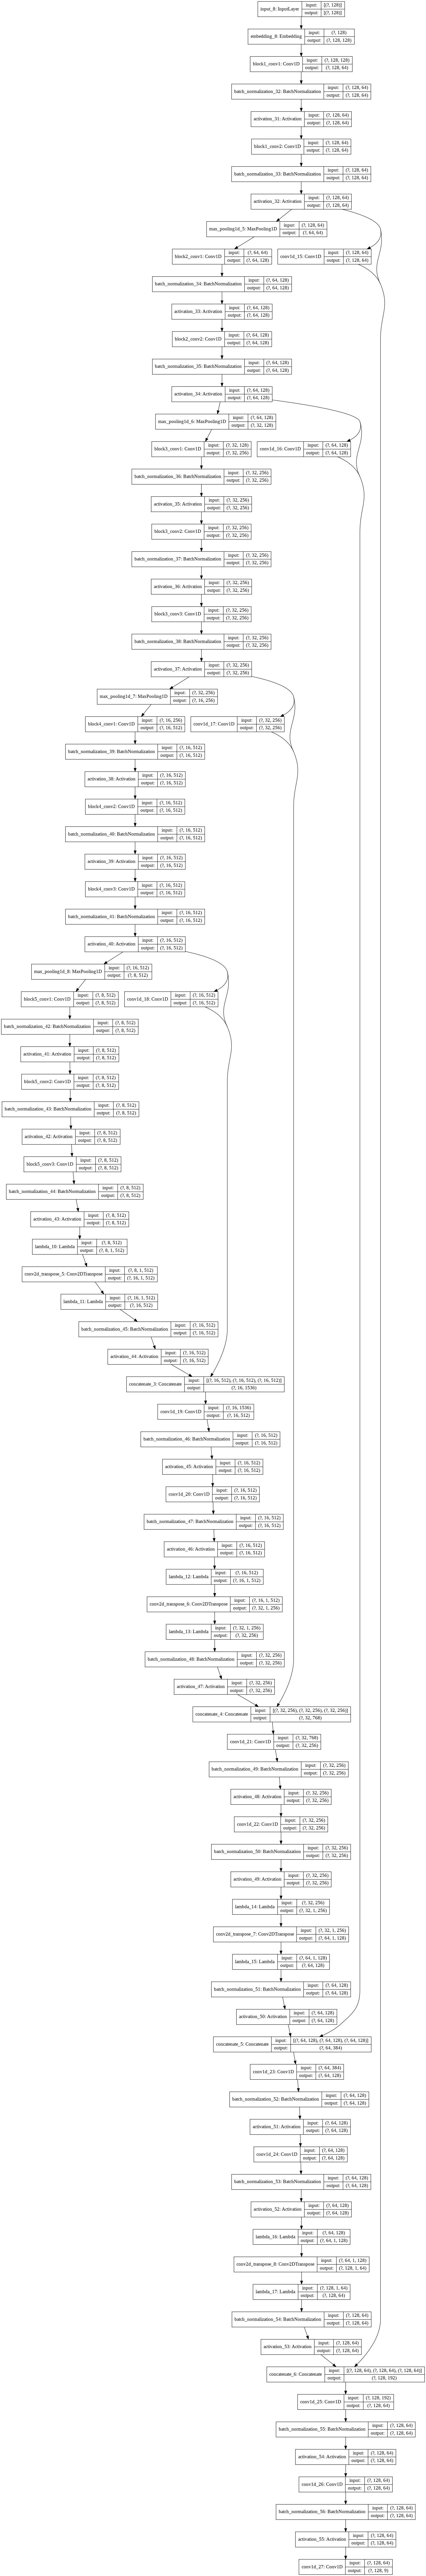

In [206]:
modelM3 = unetWithMask(colors_count, sent_len, num_words, 'sigmoid', emb_size) # Создаем модель unetWithMask
plot_model(modelM3, show_shapes=True)

In [207]:
historyM3 = modelM3.fit(Xtrain, 
                    Ytrain, 
                    epochs=100,
                    batch_size=16,
                    validation_data=(Xtest, Ytest)) #  Обучаем модель на выборке по трем классам на полноразмерных изображениях

Epoch 1/100
40/40 [==============================] - 2s 43ms/step - loss: 1.0940 - dice_coef: 0.4877 - val_loss: 1.1274 - val_dice_coef: 0.4845
Epoch 2/100
40/40 [==============================] - 1s 25ms/step - loss: 0.3778 - dice_coef: 0.7557 - val_loss: 0.7523 - val_dice_coef: 0.7471
Epoch 3/100
40/40 [==============================] - 1s 25ms/step - loss: 0.2407 - dice_coef: 0.8543 - val_loss: 0.8194 - val_dice_coef: 0.8060
Epoch 4/100
40/40 [==============================] - 1s 25ms/step - loss: 0.1263 - dice_coef: 0.9079 - val_loss: 0.9034 - val_dice_coef: 0.8250
Epoch 5/100
40/40 [==============================] - 1s 25ms/step - loss: 0.0690 - dice_coef: 0.9239 - val_loss: 1.0065 - val_dice_coef: 0.8330
Epoch 6/100
40/40 [==============================] - 1s 25ms/step - loss: 0.0414 - dice_coef: 0.9272 - val_loss: 1.0809 - val_dice_coef: 0.8363
Epoch 7/100
40/40 [==============================] - 1s 25ms/step - loss: 0.0253 - dice_coef: 0.9300 - val_loss: 1.1403 - val_dice_coef:

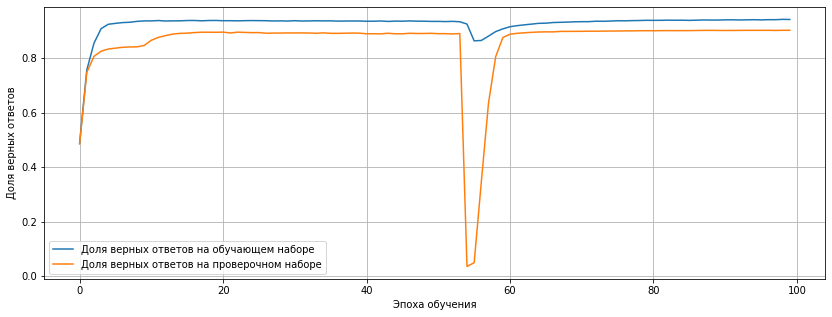

In [208]:
# Отобразим график обучения модели
plt.figure(figsize=(14, 5))
plt.plot(historyM3.history['dice_coef'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(historyM3.history['val_dice_coef'], 
         label='Доля верных ответов на проверочном наборе')
plt.grid(True)
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [209]:
YpredM3 = modelM3.predict(Xtest)

In [210]:
class_report(Ytest, YpredM3, tag_tokenizer.index_word)

o  --- 0.9776919529628776
расшифровка  --- 0.6262172284644195
определение  --- 0.6136585365853658
связка  --- 0.6893491124260355
термин  --- 0.8015873015873016
дубль-определение  --- 0.45098039215686275
дубль-расшифровка  --- 0.08163265306122448
дубль-термин  --- 0.6122448979591837
дубль-связка  --- 0.45454545454545453


In [211]:
# Встроенная функция sklearn возвращает и точность и полноту по классам
print(classification_report(Ytest.argmax(axis=-1).flatten(), YpredM3.argmax(axis=-1).flatten(), target_names=list(tag_tokenizer.index_word.values())))  

                   precision    recall  f1-score   support

                o       0.98      0.98      0.98     17361
      расшифровка       0.63      0.69      0.66      1211
      определение       0.61      0.71      0.66       886
           связка       0.69      0.81      0.75       287
           термин       0.80      0.76      0.78       266
дубль-определение       0.45      0.13      0.21       171
дубль-расшифровка       0.08      0.03      0.04       142
     дубль-термин       0.61      0.31      0.41        98
     дубль-связка       0.45      0.26      0.33        58

         accuracy                           0.92     20480
        macro avg       0.59      0.52      0.53     20480
     weighted avg       0.92      0.92      0.92     20480

